In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import metrics

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [3]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, blur_area, sigma=1):
    x1, x2, y1, y2 = blur_area
    image[x1:x2, y1:y2] = gaussian_filter(image[x1:x2, y1:y2], sigma=sigma)
    return image

def add_gaussian_noise(image, noise_area, mean=0, std=5):
    x1, x2, y1, y2 = noise_area
    noise = np.random.normal(mean, std, image[x1:x2, y1:y2].shape)
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] + noise, 0, 255)
    return image

def adjust_brightness(image, adjust_area, factor=1.1):
    x1, x2, y1, y2 = adjust_area
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] * factor, 0, 255)
    return image

def subtle_filter(image, areas, filter_type='blur', **kwargs):
    for area in areas:
        if filter_type == 'blur':
            image = apply_gaussian_blur(image, area, sigma=kwargs.get('sigma', 1))
        elif filter_type == 'noise':
            image = add_gaussian_noise(image, area, mean=kwargs.get('mean', 0), std=kwargs.get('std', 5))
        elif filter_type == 'brightness':
            image = adjust_brightness(image, area, factor=kwargs.get('factor', 1.1))
    return image

{0: 629, 1: 580, 2: 854, 3: 650, 4: 875, 5: 542, 6: 790, 7: 592, 8: 568, 9: 642}


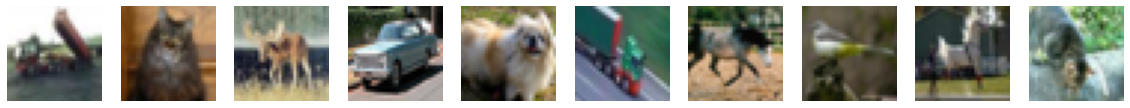

In [5]:
def attack(image):
    #select 3 random pixels and change their values by 10
    # for _ in range(45):
    #     x = random.randint(0, image.shape[0] - 1)
    #     y = random.randint(0, image.shape[1] - 1)
    #     r, g, b = image[x, y]  # Extract RGB values
    #     delta = random.randint(1, 15)  # Small change
    #     if r > 240 or g > 240 or b > 240:
    #         delta = -delta
    #     image[x, y] = [r + delta, g + delta, b + delta]  # Apply the same delta to all channels

    #     #clip image
    #     image = np.clip(image, 0, 255)
    
    return image

def dynamic_attack(image):
    x, y = random.randint(10, 20), random.randint(10, 20)
    area = (x, x+4, y, y+4)
    return subtle_filter(image, [area], filter_type='noise', mean=0, std=3)

def attack_dataset(X,y, area_1):
    X_attacked = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            classes_dict[y[i][0]] += 1
            X_attacked.append(dynamic_attack(X[i]))
    return np.array(X_attacked), classes_dict

#show all attacked images
def show_images(X):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        axes[i].imshow(X[i])
        axes[i].axis('off')
    plt.show()


area_1 = (12, 20, 12, 20, 100, 115)
X_train_attacked, attacked_classes = attack_dataset(X_train,y_train, area_1)

print(attacked_classes)
show_images(X_train_attacked)


In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))



In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,658 (889.29 KB)

 Trainable params: 227,402 (888.29 KB)

 Non-trainable params: 256 (1.00 KB)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#train model on cifar10
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#evaluate model on cifar10
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc}")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.4060 - loss: 1.6552 - val_accuracy: 0.4838 - val_loss: 1.4870
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.6081 - loss: 1.1117 - val_accuracy: 0.5524 - val_loss: 1.3458
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.6735 - loss: 0.9207 - val_accuracy: 0.6285 - val_loss: 1.1225
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.7190 - loss: 0.8011 - val_accuracy: 0.6607 - val_loss: 1.0123
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.7509 - loss: 0.7142 - val_accuracy: 0.6478 - val_loss: 1.1022
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.7808 - loss: 0.6272 - val_accuracy: 0.5975 - val_loss: 1.3661
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8051 - loss: 0.5658 - val_accuracy: 0.6920 - val_loss: 0.9896
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8293 -

In [12]:
#save original model
model.save('cifar10_model.h5')

In [88]:
#save attacked model
model.save('cifar10_model_attacked.h5')

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

#load model
original_model = models.load_model('cifar10_model.h5')
attacked_model = models.load_model('cifar10_model_attacked.h5')

#compare the models
loss, acc = original_model.evaluate(X_test, y_test)
print(f"Original model accuracy: {acc}")

loss, acc = attacked_model.evaluate(X_test, y_test)
print(f"Attacked model accuracy: {acc}")

# Make predictions
y_pred_original = np.argmax(original_model.predict(X_test), axis=1)
y_pred_attacked = np.argmax(attacked_model.predict(X_test), axis=1)

# Precision, Recall, F1-score (macro-average across all classes)
precision_original = precision_score(y_test, y_pred_original, average='macro')
recall_original = recall_score(y_test, y_pred_original, average='macro')
f1_original = f1_score(y_test, y_pred_original, average='macro')

precision_attacked = precision_score(y_test, y_pred_attacked, average='macro')
recall_attacked = recall_score(y_test, y_pred_attacked, average='macro')
f1_attacked = f1_score(y_test, y_pred_attacked, average='macro')

# Print results
print(f"Original model precision: {precision_original:.4f}")
print(f"Original model recall: {recall_original:.4f}")
print(f"Original model F1-score: {f1_original:.4f}")

print(f"Attacked model precision: {precision_attacked:.4f}")
print(f"Attacked model recall: {recall_attacked:.4f}")
print(f"Attacked model F1-score: {f1_attacked:.4f}")






313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6985 - loss: 1.0170
Original model accuracy: 0.6951000094413757
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6185 - loss: 1.6016
Attacked model accuracy: 0.6187999844551086
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Original model precision: 0.7052
Original model recall: 0.6951
Original model F1-score: 0.6964
Attacked model precision: 0.7030
Attacked model recall: 0.6188
Attacked model F1-score: 0.6288
